In [8]:
import imports
import load, fea, split, weights, model, compyl, train, ival, run

In [9]:
posf = 'input/main/rna_521.fasta'
negf = 'input/main/rna_36022.fa'
# model = run.run_pipeline(posf, negf)

In [6]:
sequences, labels = load.load_data(posf, negf)

In [7]:
merscore1, merscore2, merscore3, merscore4, merscore5, merscore6,kmer1, kmer2, kmer3 = fea.generate_features(sequences)

merscore1
merscore2
merscore3
merscore4
merscore5
merscore6


In [10]:
import numpy as np
feat = np.concatenate(
            (
                merscore1, merscore2, merscore3,
                merscore4, merscore5, merscore6,
                kmer1, kmer2, kmer3
            ),
            axis=1
        )
print(feat)

[[-0.03304854 -0.06607196 -0.08936965 ...  0.0133438   0.01203558
   0.01020408]
 [-0.0215462  -0.04248746 -0.05649342 ...  0.01436266  0.01795332
   0.01256732]
 [-0.00465218 -0.00666913  0.0031169  ...  0.01666667  0.01136364
   0.01363636]
 ...
 [ 0.03335445  0.07061261  0.13134322 ...  0.02137767  0.02019002
   0.02375297]
 [ 0.00241489  0.00942993  0.02774393 ...  0.01244813  0.01383126
   0.00691563]
 [-0.00982214 -0.0218697  -0.02628459 ...  0.01043643  0.01802657
   0.01897533]]


In [22]:
print(feat.shape)
print(labels.shape)

(36543, 90)
(36543,)


In [21]:
X = np.expand_dims(feat, axis=2).astype(np.float32)
y = labels.astype(np.float32)

print(X.shape)  # (36543, 90, 1)
print(y.shape)  # (36543,)


(36543, 90, 1)
(36543,)


In [23]:
import numpy as np

# (Optional but recommended)
X = X.astype(np.float32)
y = y.astype(np.float32)

np.save("X.npy", X)
np.save("y.npy", y)


In [6]:
import numpy as np

X = np.load("X.npy")
y = np.load("y.npy")

print(X.shape)  # (36543, 90, 1)
print(y.shape)  # (36543,)


(36543, 90, 1)
(36543,)


In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = split.stratified_split(X, y)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (23387, 90, 1) (23387,)
Val:   (5847, 90, 1) (5847,)
Test:  (7309, 90, 1) (7309,)


In [27]:
print("Train class distribution:", np.bincount(y_train.astype(int)))
print("Val class distribution:", np.bincount(y_val.astype(int)))
print("Test class distribution:", np.bincount(y_test.astype(int)))


Train class distribution: [23053   334]
Val class distribution: [5764   83]
Test class distribution: [7205  104]


In [28]:
print(y_train.shape)

(23387,)


In [45]:
import importlib
import weights

importlib.reload(weights)
# useful to reload 

<module 'weights' from '/home/jupyter-22wh1a12a2/major_project/RNA/weights.py'>

In [46]:
class_weights = weights.compute_class_weights(y_train)
print(class_weights)

{np.float32(0.0): np.float64(0.5072441764629333), np.float32(1.0): np.float64(35.01047904191617)}


In [48]:
class_weights = {
    int(k): float(v)
    for k, v in class_weights.items()
}

print(class_weights)
# Mistakes on positive samples are penalized ~35x more

{0: 0.5072441764629333, 1: 35.01047904191617}


In [4]:
from model import build_model
from compyl import compile_model

model1 = build_model()
model1 = compile_model(model1)

model1.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 90, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 90, 32)    │        128 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 90, 32)    │        192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 90, 32)    │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 90, 96)    │          0 │ conv1d_3[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_4[0][0],   │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 45, 96)    │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     41,216 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,017 (179.75 KB)

 Trainable params: 46,017 (179.75 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = train.train_model(model1, X_train, y_train, X_val, y_val)

Epoch 1/200
730/731 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6928 - pr_auc: 0.0139 - precision: 0.0142 - recall: 0.6054 - roc_auc: 0.4971
Epoch 1: val_pr_auc improved from None to 0.01420, saving model to best_model.keras

Epoch 1: finished saving model to best_model.keras
731/731 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 0.6956 - pr_auc: 0.0149 - precision: 0.0145 - recall: 0.7365 - roc_auc: 0.5094 - val_loss: 0.6903 - val_pr_auc: 0.0142 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000 - learning_rate: 0.0010
Epoch 2/200
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6851 - pr_auc: 0.0146 - precision: 0.0150 - recall: 0.4482 - roc_auc: 0.5089
Epoch 2: val_pr_auc did not improve from 0.01420
731/731 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - loss: 0.6934 - pr_auc: 0.0150 - precision: 0.0155 - recall: 0.5419 - roc_auc: 0.5159 - val_loss: 0.6970 - val_pr_auc: 0.0142 - val_precision: 0.0142 - val_recall: 1.0000 - val_roc_auc: 0.5000 - learning_rate: 0.0010
Epo

In [13]:
results = model1.evaluate(X_test, y_test, verbose=0)

for name, value in zip(model1.metrics_names, results):
    print(f"{name}: {value:.4f}")


loss: 0.2047
compile_metrics: 0.5758


In [15]:
results = model1.evaluate(X_test, y_test, verbose=0, return_dict=True)
print(results)


{'loss': 0.20472325384616852, 'pr_auc': 0.5758102536201477, 'precision': 0.12927190959453583, 'recall': 0.8365384340286255, 'roc_auc': 0.9552714824676514}


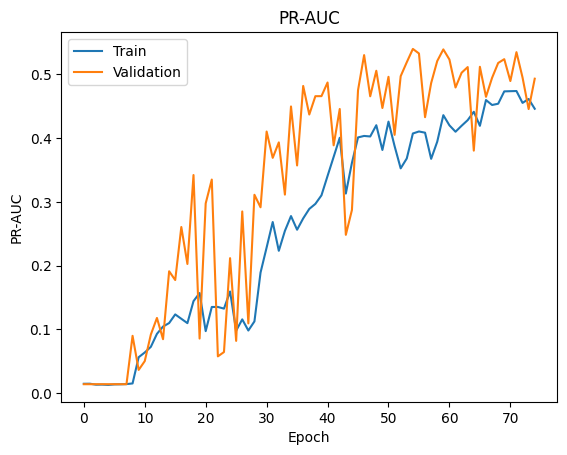

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['pr_auc'])
plt.plot(history.history['val_pr_auc'])
plt.title('PR-AUC')
plt.xlabel('Epoch')
plt.ylabel('PR-AUC')
plt.legend(['Train', 'Validation'])
plt.show()


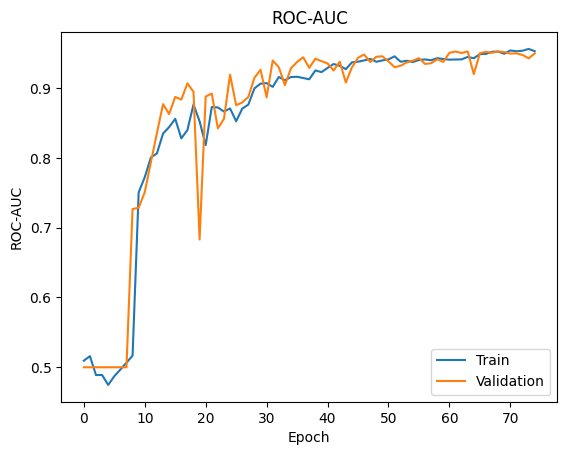

In [17]:
plt.plot(history.history['roc_auc'])
plt.plot(history.history['val_roc_auc'])
plt.title('ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend(['Train', 'Validation'])
plt.show()


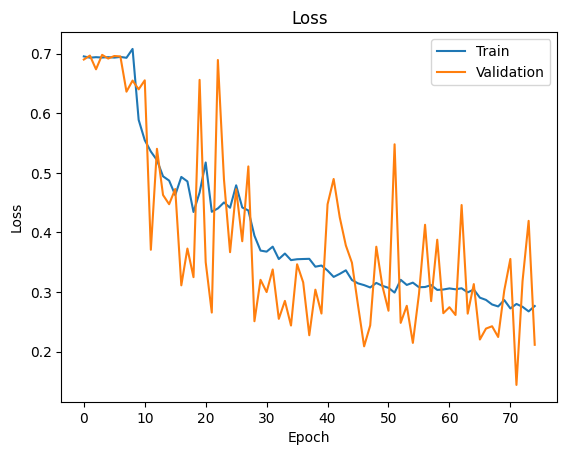

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()
